# Yelp Coffee Shop Reviews Analysis

As competition continues to grow, online ratings and reviews will prove to play an
important role in the success of new and existing businesses. One highly competitive market in
the Austin metropolitan area is coffee shops. As an existing coffee shop, or a new entrant into the
market, understanding how people are talking about your shop, how satisfied people are with
your shop (through ratings), and what attributes of your shop are influential in those ratings will
help you prioritize aspects of your shop that will determine its success. Furthermore,
understanding how your competitors, and the market in general, is viewed by the public will help
you gain a competitive advantage. The following analysis project aims to uncover insights that
would help coffee shop owners understand their business as well as their competitors, and create
a model for predicting coffee shop success and satisfaction (ratings). 

### Methodology:
1. Collected 7k reviews on coffee shops from Austin from Yelp.com with a row for each
review, and columns with the following data: coffee shop name, review text, and review
score (all coffee shop reviews from Austin as of December 7th).
2. Ran the word frequency analysis script to determine what common “attributes” are
discussed in relation to coffee shops. Used a “find and replace” macro to merge attributes
that mean the same thing (details below).
3. Modified parseforsentiment.py to review chunks for each attribute, ran through
SentiStrength, and combined “chunk” sentiments into a CSV for analysis.

In [2]:
import pandas as pd
from pandas import Series, DataFrame
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
ratings_df = pd.read_csv("ratings_and_sentiments.csv")
ratings_df = ratings_df.drop_duplicates()
ratings_df = ratings_df.replace('#VALUE!', np.nan)
ratings_df['vibe_sent'] = pd.to_numeric(ratings_df['vibe_sent'])
ratings_df['parking_sent'] = pd.to_numeric(ratings_df['vibe_sent'])
ratings_df['coffee_sent'] = pd.to_numeric(ratings_df['coffee_sent'])
ratings_df['food_sent'] = pd.to_numeric(ratings_df['food_sent'])
shops_df = pd.pivot_table(ratings_df, index = 'coffee_shop_name')

### What is the distribution of ratings versus overall sentiments for reviews overall?

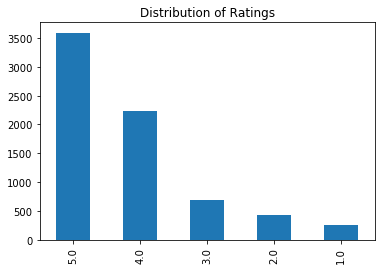

In [4]:
ratings_df['num_rating'].value_counts().plot(kind='bar', title = 'Distribution of Ratings')

**Findings:**
The average rating from all reviews of Austin coffee shops is 4.169 out of 5. The distribution above also shows that online reviews are heavily positively skewed, with over 80.7% of reviews being 4 or 5 stars.

This suggests that in the review world, giving less than 4 stars as a rating qualifies as a “bad review”, giving 4 stars is actually fairly neutral, and giving 5 stars means it was a top quality experience.

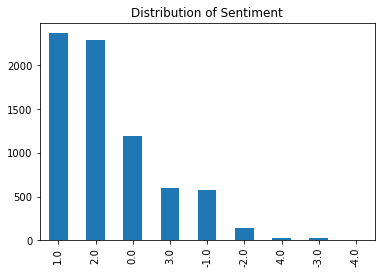

In [5]:
overall_sent_ser = ratings_df['overall_sent'].value_counts()
overall_sent_ser.plot(kind='bar', title = 'Distribution of Sentiment')

**Findings:** The average overall sentiment of a review was 1.107, meaning slightly positive. In fact, 73.2% of reviews are positive (> 0 overall sentiment), as compared to 16.6% neutral and 10.2% negative. Futhermore, review sentiments are rarely "extreme" with a sentiment greater than or equal to 3, or less than or equal to -3. This suggests that reviews on coffee shops are overall positive and comparatively moderate in their sentiment.

In [6]:
ratings_df.mean()

num_rating       4.173202
bool_HIGH        0.807676
overall_sent     1.097547
vibe_sent        0.370100
tea_sent         0.046280
service_sent     0.326729
seating_sent     0.122489
price_sent       0.020091
parking_sent     0.370100
location_sent    0.075655
alcohol_sent     0.041291
coffee_sent      0.512749
food_sent        0.355183
hours_sent       0.031042
internet_sent    0.025634
local_sent       0.037412
dtype: float64

### Does sentiment vary based on "good ratings", "bad ratings" or "neutral ratings"?
As you can see above, star ratings can be interpreted very differently when you see their distribution. So, I adjusted the model to have new variables - “good rating” if the rating was 5 stars, “bad rating” if the rating was less than 4 stars, and "neutral rating" if the rating was 4 stars.

In [7]:
def categorize_rating(row):
    num = row['num_rating']
    if num == 5.0:
        return "good"
    elif num == 4.0:
        return "neutral"
    else:
        return "bad"

ratings_df['cat_rating'] = ratings_df.apply(categorize_rating, axis = 1)

Average sentiment:  1.47856347439


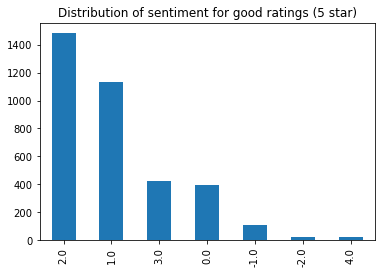

In [8]:
mask = ratings_df['cat_rating'] == "good"
good_ratings_ser = ratings_df[mask]['overall_sent'].value_counts()
print "Average sentiment: ", ratings_df[mask]['overall_sent'].mean()
good_ratings_ser.plot(kind = 'bar', title = "Distribution of sentiment for good ratings (5 star)")

Average sentiment:  1.16852928029


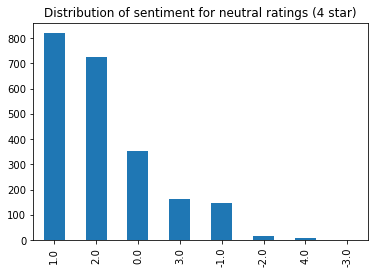

In [9]:
mask = ratings_df['cat_rating'] == "neutral"
neutral_ratings_ser = ratings_df[mask]['overall_sent'].value_counts()
print "Average sentiment: ", (ratings_df[mask]['overall_sent'].mean())
neutral_ratings_ser.plot(kind = 'bar', title = "Distribution of sentiment for neutral ratings (4 star)")

Average sentiment:  -0.0028818443804


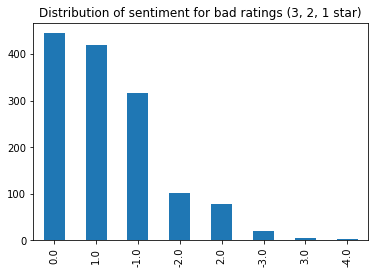

In [10]:
mask = ratings_df['cat_rating'] == "bad"
bad_ratings_ser = ratings_df[mask]['overall_sent'].value_counts()
print "Average sentiment: ", (ratings_df[mask]['overall_sent'].mean())
bad_ratings_ser.plot(kind = 'bar', title = "Distribution of sentiment for bad ratings (3, 2, 1 star)")

In [11]:
compare_sent_of_ratings_df = pd.concat([overall_sent_ser, good_ratings_ser, neutral_ratings_ser, bad_ratings_ser], axis=1)
compare_sent_of_ratings_df.columns = ['all_reviews','good_reviews','neutral_reviews','bad_reviews']

def calc_percent_change(row, col):
    try:
        col_pc = row[col]/compare_sent_of_ratings_df[col].sum()
        all_pc = row['all_reviews']/compare_sent_of_ratings_df['all_reviews'].sum()
        pc_change = (col_pc - all_pc) / all_pc 
    except:
        pc_change = None
    return pc_change

columns = ['good_reviews','neutral_reviews','bad_reviews']
for c in columns:
    c_new = "PC_" + c
    compare_sent_of_ratings_df[c_new] = compare_sent_of_ratings_df.apply(calc_percent_change, args = (c,) ,axis = 1)

**Findings**: The average sentiment of "good reviews" is 1.478, "neutral reviews" is 1.168, and "bad reviews" is -.002 as compared to the overall average sentiment of 1.097. Most good reviews, have a sentiment of 2, while neutral reviews have a sentiment of 1 and negative reviews have a sentiment of 0. This demonstrates how reviews are naturally positively skewed, either by human nature of not wanting to be overly negative in a public forum about a bad experience (since Yelp does tie your user profile to reviews), or because even when we are critiquing an experience, we tend to use less strong words and compliment the redeeming qualities.

### What does the distribution of sentiment look like around each attribute? Are there attributes that are more polarizing or elicit stronger sentiments than others?

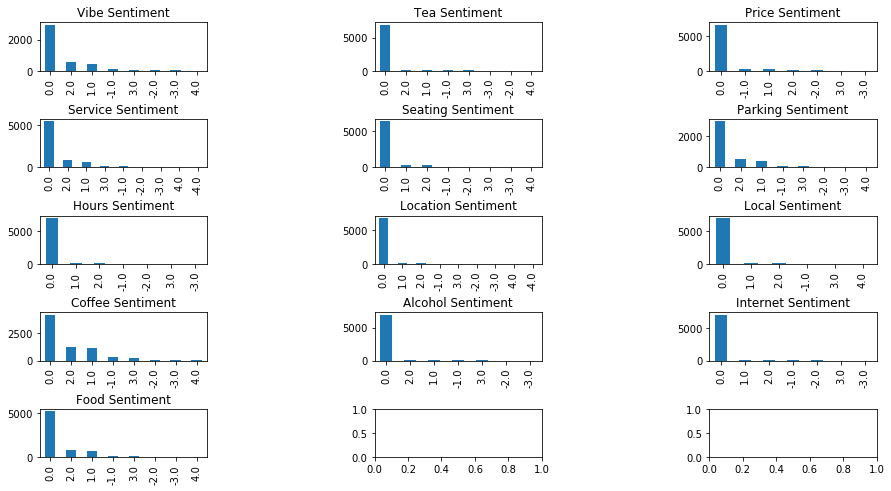

In [12]:
fig, axes = plt.subplots(nrows=5, ncols=3)
fig.subplots_adjust(hspace=1, wspace = 1)
ratings_df['vibe_sent'].value_counts().plot(kind = 'bar',ax=axes[0,0], title = 'Vibe Sentiment',figsize=(15,8))
ratings_df['tea_sent'].value_counts().plot(kind = 'bar',ax=axes[0,1], title = 'Tea Sentiment')
ratings_df['service_sent'].value_counts().plot(kind = 'bar',ax=axes[1,0], title = 'Service Sentiment')
ratings_df['seating_sent'].value_counts().plot(kind = 'bar',ax=axes[1,1], title = 'Seating Sentiment')
ratings_df['price_sent'].value_counts().plot(kind = 'bar',ax=axes[0,2], title = 'Price Sentiment')
ratings_df['parking_sent'].value_counts().plot(kind = 'bar',ax=axes[1,2], title = 'Parking Sentiment')
ratings_df['location_sent'].value_counts().plot(kind = 'bar',ax=axes[2,1], title = 'Location Sentiment')
ratings_df['alcohol_sent'].value_counts().plot(kind = 'bar',ax=axes[3,1], title = 'Alcohol Sentiment')
ratings_df['coffee_sent'].value_counts().plot(kind = 'bar',ax=axes[3,0], title = 'Coffee Sentiment')
ratings_df['food_sent'].value_counts().plot(kind = 'bar',ax=axes[4,0], title = 'Food Sentiment')
ratings_df['hours_sent'].value_counts().plot(kind = 'bar',ax=axes[2,0], title = 'Hours Sentiment')
ratings_df['internet_sent'].value_counts().plot(kind = 'bar',ax=axes[3,2], title = 'Internet Sentiment')
ratings_df['local_sent'].value_counts().plot(kind = 'bar',ax=axes[2,2], title = 'Local Sentiment')

In [13]:
compare_df = pd.concat([ratings_df.mean(),ratings_df.std()], axis=1, join='outer')
compare_df.columns = ['mean','std_deviation']
compare_df

,mean,std_deviation
num_rating,4.173202,1.062846
bool_HIGH,0.807676,0.394153
overall_sent,1.097547,1.179282
vibe_sent,0.370100,0.835968
tea_sent,0.046280,0.330990
service_sent,0.326729,0.828535
seating_sent,0.122489,0.516593
price_sent,0.020091,0.373396
parking_sent,0.370100,0.835968
location_sent,0.075655,0.398635


**Findings:** The mean above shows the average sentiment of all reviews regarding this attribute, and the standard deviation is a measure of variety in sentiment. From the data above, you can see that people have the most positive sentiment towards coffee, parking, vibe, food and service (when they are mentioned). On average, the sentiments are neutral regarding tea, price, location, alcohol, hours, internet and local. However, every attribute has a standard deviation higher than .25 sentiment, meaning that many of the neutral attributes could frequently be given negative sentiments.

In [14]:
good_ratings_avg_df = ratings_df[ratings_df['cat_rating'] == "good"].mean()
bad_ratings_avg_df = ratings_df[ratings_df['cat_rating'] == "bad"].mean()
neutral_ratings_avg_df = ratings_df[ratings_df['cat_rating'] == "neutral"].mean()
overall_ratings_avg_df = ratings_df.mean()

compare_att_sent_df = pd.concat([overall_ratings_avg_df, good_ratings_avg_df, neutral_ratings_avg_df, bad_ratings_avg_df], axis=1)
compare_att_sent_df.columns = ['all_reviews','good_reviews','neutral_reviews','bad_reviews']
compare_att_sent_df

,all_reviews,good_reviews,neutral_reviews,bad_reviews
num_rating,4.173202,5.000000,4.000000,2.312680
bool_HIGH,0.807676,1.000000,1.000000,0.000000
overall_sent,1.097547,1.478563,1.168529,-0.002882
vibe_sent,0.370100,0.415025,0.382236,0.199095
tea_sent,0.046280,0.054009,0.044703,0.028818
service_sent,0.326729,0.464644,0.293697,0.023055
seating_sent,0.122489,0.118875,0.164506,0.064121
price_sent,0.020091,0.038976,0.017434,-0.024496
parking_sent,0.370100,0.415025,0.382236,0.199095
location_sent,0.075655,0.075445,0.079571,0.069885


In [15]:
def calc_percent_change_2(row, col):
    try:
        pc_change = (row[col] - row['all_reviews']) / row['all_reviews'] 
    except:
        pc_change = None
    return pc_change

columns = ['good_reviews','neutral_reviews','bad_reviews']
for c in columns:
    c_new = "PC_" + c
    compare_att_sent_df[c_new] = compare_att_sent_df.apply(calc_percent_change_2, args = (c,) ,axis = 1)

compare_att_sent_df

,all_reviews,good_reviews,neutral_reviews,bad_reviews,PC_good_reviews,PC_neutral_reviews,PC_bad_reviews
num_rating,4.173202,5.000000,4.000000,2.312680,0.198121,-0.041503,-0.445826
bool_HIGH,0.807676,1.000000,1.000000,0.000000,0.238120,0.238120,-1.000000
overall_sent,1.097547,1.478563,1.168529,-0.002882,0.347152,0.064673,-1.002626
vibe_sent,0.370100,0.415025,0.382236,0.199095,0.121387,0.032792,-0.462050
tea_sent,0.046280,0.054009,0.044703,0.028818,0.167013,-0.034073,-0.377297
service_sent,0.326729,0.464644,0.293697,0.023055,0.422109,-0.101098,-0.929438
seating_sent,0.122489,0.118875,0.164506,0.064121,-0.029499,0.343032,-0.476514
price_sent,0.020091,0.038976,0.017434,-0.024496,0.939905,-0.132265,-2.219209
parking_sent,0.370100,0.415025,0.382236,0.199095,0.121387,0.032792,-0.462050
location_sent,0.075655,0.075445,0.079571,0.069885,-0.002766,0.051763,-0.076267


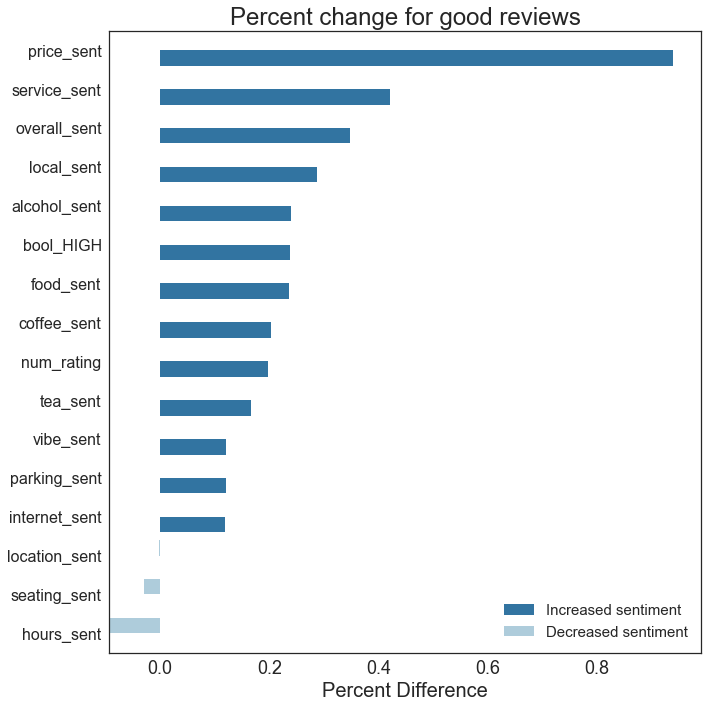

In [16]:
import seaborn as sns
sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))

sorted_to_chart = compare_att_sent_df.sort_values(by='PC_good_reviews', ascending=False)
sorted_to_chart['dummy'] = sorted_to_chart.PC_good_reviews.apply(lambda x: 1 if x > 0 else 0)

plt.figure(figsize=(10,10))
fig = sns.barplot(y=sorted_to_chart.index, x=sorted_to_chart.PC_good_reviews, hue=sorted_to_chart.dummy)

plt.title('Percent change for good reviews', fontsize=24)
plt.ylabel('')
plt.xlabel('Percent Difference',fontsize=20)
loc, labels = plt.xticks()
yloc, ylabels=plt.yticks()
plt.yticks(fontsize=16)
plt.xticks(fontsize=18)
handles, labels = fig.get_legend_handles_labels()
plt.legend(handles=[handles[1],handles[0]], labels = ['Increased sentiment','Decreased sentiment'], loc=0, fontsize=15 )
plt.tight_layout()
plt.show()


**Findings:** Average sentiment increases on all attributes except location, seating and hours for "good reviews" with a 5 star rating. The highest percent change comes from sentiment around Price with a 93% change, suggesting that if people are giving a 5 star review, they are more likely to express a stronger positive sentiment towards the price of the coffee shop.

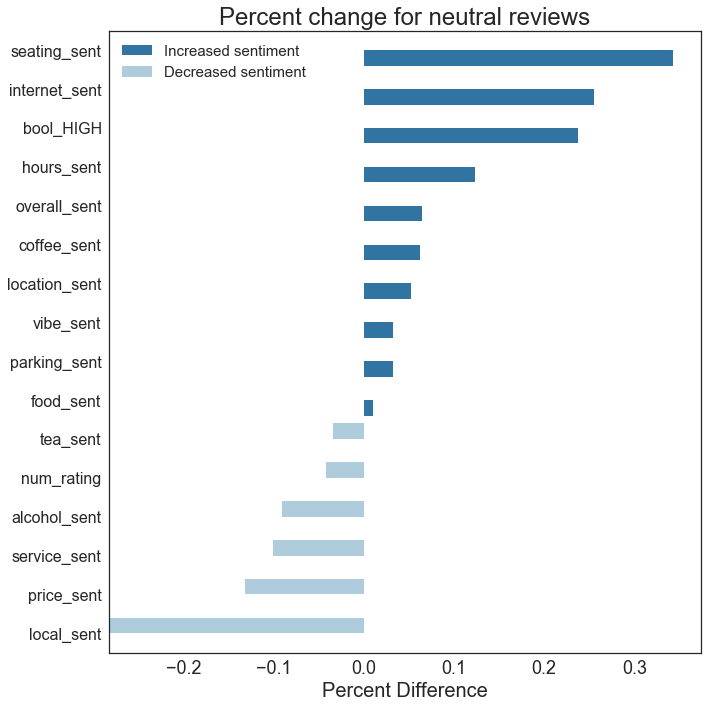

In [17]:
sorted_to_chart = compare_att_sent_df.sort_values(by='PC_neutral_reviews', ascending=False)
sorted_to_chart['dummy'] = sorted_to_chart.PC_neutral_reviews.apply(lambda x: 1 if x > 0 else 0)

plt.figure(figsize=(10,10))
fig = sns.barplot(y=sorted_to_chart.index, x=sorted_to_chart.PC_neutral_reviews, hue=sorted_to_chart.dummy)

plt.title('Percent change for neutral reviews', fontsize=24)
plt.ylabel('')
plt.xlabel('Percent Difference',fontsize=20)
loc, labels = plt.xticks()
yloc, ylabels=plt.yticks()
plt.yticks(fontsize=16)
plt.xticks(fontsize=18)
handles, labels = fig.get_legend_handles_labels()
plt.legend(handles=[handles[1],handles[0]], labels = ['Increased sentiment','Decreased sentiment'], loc=0, fontsize=15 )
plt.tight_layout()
plt.show()

**Findings:** For "neutral reviews" of 4 stars, the highest percent change in positive sentiment are seating and internet with 34% and 25% change respectively. This suggests that people giving a coffee shop a 4 star rating are more likely to have strong positive sentiment around seating and internet - meaning these two attributes could play a strong role in having a neutral experience at a coffee shop (not overly great and not horrible). 

Also notably, neutral reviews are more likely to have negative sentiment around whether or not the coffee shop was local - suggesting that even if a coffee shop is a good experience, if it's not local, people are more likely to give it a 4 star rating. This fits well with Austin's culture and preference for local businesses.

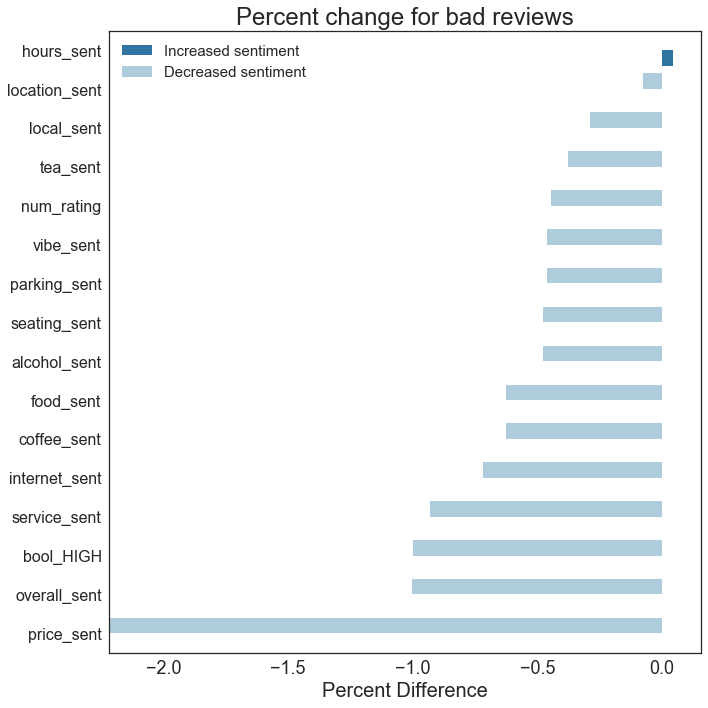

In [18]:
sorted_to_chart = compare_att_sent_df.sort_values(by='PC_bad_reviews', ascending=False)
sorted_to_chart['dummy'] = sorted_to_chart.PC_bad_reviews.apply(lambda x: 1 if x > 0 else 0)

plt.figure(figsize=(10,10))
fig = sns.barplot(y=sorted_to_chart.index, x=sorted_to_chart.PC_bad_reviews, hue=sorted_to_chart.dummy)

plt.title('Percent change for bad reviews', fontsize=24)
plt.ylabel('')
plt.xlabel('Percent Difference',fontsize=20)
loc, labels = plt.xticks()
yloc, ylabels=plt.yticks()
plt.yticks(fontsize=16)
plt.xticks(fontsize=18)
handles, labels = fig.get_legend_handles_labels()
plt.legend(handles=[handles[1],handles[0]], labels = ['Increased sentiment','Decreased sentiment'], loc=0, fontsize=15 )
plt.tight_layout()
plt.show()

**Findings**: The average bad review (1, 2 or 3 stars) has significantly more negative sentiment towards price with a -222% change in sentiment. This suggests that when people are reviewing coffee shops negatively, they are likely to express the strongest negative sentiment towards the price - perhaps that they didn't get the value for which they believe they paid for. 

Also notably, service, internet, coffee, and food have more than -50 percent changes in sentiment suggesting these attributes are also more likely to be discussed with a strong negative sentiment in bad reviews.

### Becoming a top coffee shop - what are the major differences between the top 10 coffee shops and bottom 10 coffee shops?
Note: Selected top 10 and bottom 10 by average rating with more than 50 reviews.

In [19]:
review_count = ratings_df['coffee_shop_name'].value_counts()
shops_df['num_reviews'] = review_count
shops_df_filter = shops_df[shops_df['num_reviews']>49].sort_values(by=['num_rating'], ascending = False)
top_10_shops_df = shops_df_filter.head(10).reset_index()
bottom_10_shops_df = shops_df_filter.tail(10).reset_index()

The average rating of Top 10 is  4.62854589864
The average sentiment of Top 10 is  1.28669321609
The average rating of Bottom 10 is  3.7425920398
The average sentiment of Bottom 10 is  0.819263681592


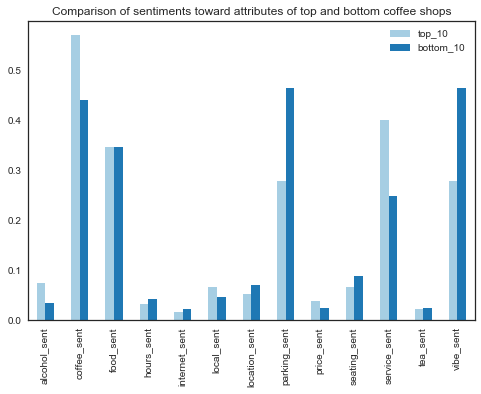

In [20]:
compare_shops_avg_df = pd.concat([top_10_shops_df.mean(),bottom_10_shops_df.mean()], axis=1)
compare_shops_avg_df.columns = ['top_10','bottom_10']
print "The average rating of Top 10 is ", compare_shops_avg_df['top_10']['num_rating']
print "The average sentiment of Top 10 is ", compare_shops_avg_df['top_10']['overall_sent']
print "The average rating of Bottom 10 is ", compare_shops_avg_df['bottom_10']['num_rating']
print "The average sentiment of Bottom 10 is ", compare_shops_avg_df['bottom_10']['overall_sent']
plot_df = compare_shops_avg_df.drop(compare_shops_avg_df.index[[1,8,9,16]])
plot_df.plot(kind = 'bar', title = 'Comparison of sentiments toward attributes of top and bottom coffee shops')

**Findings:** You can see the biggest difference in average sentiment occurs on attributes of coffee and service. Top 10 coffee shops have much higher average sentiments in these attributes than bottom 10 coffee shops. Interestingly, bottom 10 coffee shops have a higher sentiment towards parking and vibe. This suggests that even if a coffee shop is rated poorly, patrons are more likely to comment positively about the vibe or parking available.

### What are the top 10 coffee shops by rating? What are the top 10 coffee shops by sentiment?

In [21]:
shops_df_filter = shops_df_filter.sort_values(by=['overall_sent'], ascending = False)
top_10_sent_df = shops_df_filter.head(10)
print "TOP SHOPS BY RATING"
print top_10_shops_df[['coffee_shop_name','overall_sent','num_rating']]
print "\n \n"
print "TOP SHOPS BY SENTIMENT"
print top_10_sent_df[['overall_sent','num_rating']]

TOP SHOPS BY RATING
                       coffee_shop_name  overall_sent  num_rating
0  Third Coast Coffee Roasting Company       1.071429    4.821429
1               Venezia Italian Gelato       1.780000    4.810000
2                         Fleet Coffee       1.228070    4.701754
3                           Dolce Neve       1.520000    4.640000
4            Anderson's Coffee Company       1.150000    4.620000
5                    Flat Track Coffee       1.142857    4.571429
6                 Apanas Coffee & Beer       1.474576    4.550847
7                        Corona Coffee       1.270000    4.530000
8                Summermoon Coffee Bar       1.180000    4.530000
9                      Live Oak Market       1.050000    4.510000

 

TOP SHOPS BY SENTIMENT
                                 overall_sent  num_rating
coffee_shop_name                                         
Venezia Italian Gelato               1.780000    4.810000
The Factory - Cafe With a Soul       1.580645    4.37

In [22]:
import subprocess
subprocess.call("jupyter nbconvert notebook.ipynb --to pdf")

OSError: [Errno 2] No such file or directory